# Notebook to compare the performance of interval based TSC



In [2]:
import numpy as np
import pandas as pd
import os
import sys
import time as time
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(1, module_path + '/src')
import utility

import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.classification.interval_based import RandomIntervalSpectralForest


import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix


from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 7, weight = 1000)
color_map = ['#8ECAE6', '#219EBC', '#023047', '#FFB703', '#FB8500']
class_names = ['crackle', 'no-crackle']

In [6]:
X, y = load_from_tsfile_to_dataframe(module_path + '/data/ts_files/crackleNoCrackle_3000_same_ESSUA.ts')
X, y = shuffle(X, y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y)

labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['0' '1'] [1741 3056]


Alternatively loading seperate datasets for train / test

In [3]:
X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/data/ts_files/crackleNoCrackle_3000_same_ESSUA.ts')
X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/data/ts_files/crackleNoCrackle_3000_same_AUTH.ts')
X_train, y_train  = shuffle(X_train, y_train , random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)
labels_test, counts_test = np.unique(y_test, return_counts=True)
print(labels_test, counts_test)

['0' '1'] [2316 4080]
['0' '1'] [ 54 448]


## Time series forest (TSF)

In [3]:
start = time.time()
tsf = TimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf_y_pred = tsf.predict(X_test)
print(f'Number of mislabeled points out of a total {X_test.shape[0]} points : {(y_test != tsf_y_pred).sum()}')
print(classification_report(tsf_y_pred, y_test))
end = time.time()
print('Time: ', str(end - start))

Number of mislabeled points out of a total 1667 points : 503
              precision    recall  f1-score   support

           0       0.34      0.62      0.44       319
           1       0.89      0.72      0.79      1348

    accuracy                           0.70      1667
   macro avg       0.61      0.67      0.62      1667
weighted avg       0.78      0.70      0.73      1667

Time:  6202.181675195694


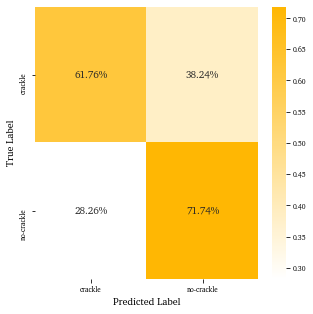

In [4]:

cm = confusion_matrix(tsf_y_pred, y_test)
f, ax = plt.subplots(1,1) # 1 x 1 array , can also be any other size
f.set_size_inches(5, 5)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

colors_2 = ['#FFFFFF', color_map[3]]
cmap_name = 'my colormap'
cm_map = LinearSegmentedColormap.from_list(cmap_name, colors_2)

ax = sns.heatmap(cm, annot=True,
            fmt='.2%', cmap=cm_map, xticklabels=class_names,yticklabels=class_names )
cbar = ax.collections[0].colorbar
for label in ax.get_yticklabels() :
    label.set_fontproperties(font_small)
for label in ax.get_xticklabels() :
    label.set_fontproperties(font_small)
ax.set_ylabel('True Label', fontproperties = font)
ax.set_xlabel('Predicted Label', fontproperties = font)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)

for child in ax.get_children():
    if isinstance(child, matplotlib.text.Text):
        child.set_fontproperties(font)
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_fontproperties(font_small)

## RISE

In [7]:
start = time.time()
rise = RandomIntervalSpectralForest(n_estimators=10)
rise.fit(X_train, y_train)
end = time.time()
print('Train Time: ', str(end - start))
start = time.time()
rise_y_pred = rise.predict(X_test)
print(f'Number of mislabeled points out of a total {X_test.shape[0]} points : {(y_test != rise_y_pred).sum()}')
print(classification_report(rise_y_pred, y_test))
end = time.time()
print('Predict Time: ', str(end - start))

Train Time:  592.4397547245026
Number of mislabeled points out of a total 1599 points : 586
              precision    recall  f1-score   support

           0       0.23      0.48      0.32       281
           1       0.86      0.67      0.75      1318

    accuracy                           0.63      1599
   macro avg       0.55      0.57      0.53      1599
weighted avg       0.75      0.63      0.67      1599

Predict Time:  201.23422932624817


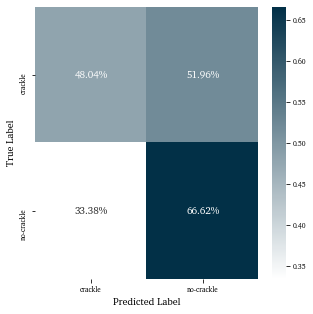

In [8]:
cm = confusion_matrix(rise_y_pred, y_test)
f, ax = plt.subplots(1,1) # 1 x 1 array , can also be any other size
f.set_size_inches(5, 5)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

colors_2 = ['#FFFFFF', color_map[2]]
cmap_name = 'my colormap'
cm_map = LinearSegmentedColormap.from_list(cmap_name, colors_2)

ax = sns.heatmap(cm, annot=True,
            fmt='.2%', cmap=cm_map, xticklabels=class_names,yticklabels=class_names )
cbar = ax.collections[0].colorbar
for label in ax.get_yticklabels() :
    label.set_fontproperties(font_small)
for label in ax.get_xticklabels() :
    label.set_fontproperties(font_small)
ax.set_ylabel('True Label', fontproperties = font)
ax.set_xlabel('Predicted Label', fontproperties = font)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)

for child in ax.get_children():
    if isinstance(child, matplotlib.text.Text):
        child.set_fontproperties(font)
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_fontproperties(font_small)